In [1]:
#Import packages
import numpy as np
from numpy import argmax
import pyspark.sql.functions as F
import snowflake.connector
import pandas as pd
import spacy
#from sparknlp.base import Finisher, DocumentAssembler
#from sparknlp.annotator import  Normalizer, LemmatizerModel, StopWordsCleaner, Tokenizer
#from pyspark.ml import Pipeline
#from pyspark.ml.feature import CountVectorizer, VectorAssembler, HashingTF, IDF, Tokenizer
#from nltk.corpus import stopwords
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from scipy import sparse
from sklearn.linear_model import LogisticRegression
from sklearn import svm
from sklearn.multiclass import OneVsRestClassifier
from sklearn import metrics
from sklearn.metrics import f1_score, accuracy_score, recall_score, precision_score, confusion_matrix, plot_confusion_matrix, \
                            roc_curve, auc, classification_report, precision_recall_curve
import matplotlib.pyplot as plt
import boto3
import json

VBox()

Starting Spark application


ID,YARN Application ID,Kind,State,Spark UI,Driver log,Current session?
1,application_1612881296901_0002,pyspark,idle,Link,Link,✔


FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

SparkSession available as 'spark'.


FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [2]:
sm_client = boto3.client('secretsmanager',region_name='us-west-2')
secret_value = sm_client.get_secret_value(SecretId = 'emr_spark_qa')
username = json.loads(secret_value['SecretString'])['emr_spark_username']
password = json.loads(secret_value['SecretString'])['emr_spark_password']

#SPARK connection info
sfOptions = {
  'sfURL' : 'powerreviews.snowflakecomputing.com',
  'sfAccount' : 'powerreviews',
  'sfUser' : username,
  'sfPassword' : password,
  'sfDatabase' : 'ANALYTICS_PROD',
  'sfSchema' : 'ANALYTICS',
  'sfWarehouse' : 'LOWER_ENV_WAREHOUSE'
}
SNOWFLAKE_SOURCE_NAME = "net.snowflake.spark.snowflake"

#PYTHON connection info
conn = snowflake.connector.connect(
    account='powerreviews',
    database='analytics_prod',
    warehouse='LOWER_ENV_WAREHOUSE',
    user=username,
    password=password
    )


VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [3]:
#Use review data set to get observation codes bc they are already comma separated and less joins to perform
#Still need observation set though to get observation created date
#This is bc review could be from ages ago but we could have imported recently and moderated it
#Want to make sure we include as many observation labels as possible for most accurate model



VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [4]:
query = "select distinct r.ugc_id, r.created_date, r.review_headline, r.review_rating, \
r.review_comments, r.review_rating, r.reviewer_nickname, r.locale, r.observations, \
ADD IN CASE WHEN HERE \
from analytics.review as r \
left join cdm.observation as o \
on r.ugc_id = o.ugc_id \
where contains(r.observations, 'PM') \
and r.locale in ('en_US','en_GB','en_CA') \
and o.created_date > '2020-09-23'  \
limit 100"

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [5]:
#Careful not to get CNR for NR
#CNR, NR, PM - contains(r.observations, ',NR,')
#NR, PM - substring(r.observations, 1, 2) = 'NR'
#CNR, PM - DONT WANT

query_testing = "select distinct r.ugc_id,  r.review_headline, r.review_comments, r.review_rating, \
case when (contains(r.observations, ',NR,') or substring(r.observations, 1, 2) = 'NR')  then 1 else 0 end as NR, \
case when contains(r.observations, 'CS') then 1 else 0 end as CS \
from analytics.review as r \
where r.locale in ('en_US','en_GB','en_CA') and contains(r.observations, 'PM') and not contains(r.observations, 'IA') and not contains(r.observations, 'IR') \
and (contains(r.observations, ',NR,') or substring(r.observations, 1, 2) = 'NR') \
and r.created_date > '2020-01-01' \
 "

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [6]:
#pd.set_option('display.max_colwidth', -1)
#pd.set_option('display.max_columns', None)
#pd.set_option('display.max_rows', None)
reviews = pd.read_sql(query_testing, conn)
reviews.head(100)
#reviews.info()


VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

       UGC_ID                                    REVIEW_HEADLINE  ... NR  CS
0   308014468                                 In all my 71 years  ...  1   0
1   284211201                                               Yoyo  ...  1   0
2   314500594                          9pcs Turquoise Blue Brush  ...  1   0
3   284215922                   HOW DO I INFLATE THE RAINBOW????  ...  1   0
4   314500543                                           The Zulu  ...  1   0
..        ...                                                ...  ... ..  ..
95  284284512                                                yes  ...  1   0
96  270371951  No I will not buy this item. I want 000980 and...  ...  1   0
97  298293918                                             5 Star  ...  1   0
98  298298514                                        Undisclosed  ...  1   0
99  298342989                                The one that got me  ...  1   0

[100 rows x 6 columns]

In [7]:
reviews.info()

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 391785 entries, 0 to 391784
Data columns (total 6 columns):
 #   Column           Non-Null Count   Dtype 
---  ------           --------------   ----- 
 0   UGC_ID           391785 non-null  int64 
 1   REVIEW_HEADLINE  391785 non-null  object
 2   REVIEW_COMMENTS  391540 non-null  object
 3   REVIEW_RATING    391785 non-null  int64 
 4   NR               391785 non-null  int64 
 5   CS               391785 non-null  int64 
dtypes: int64(4), object(2)
memory usage: 17.9+ MB

In [8]:
query_testing_2 = "select distinct r.ugc_id,  r.review_headline, r.review_comments, r.review_rating, \
case when (contains(r.observations, ',NR,') or substring(r.observations, 1, 2) = 'NR')  then 1 else 0 end as NR, \
case when contains(r.observations, 'CS') then 1 else 0 end as CS \
from analytics.review as r \
where r.locale in ('en_US','en_GB','en_CA') and contains(r.observations, 'PM') and not contains(r.observations, 'IA') and not contains(r.observations, 'IR') \
and not contains(r.observations, ',NR,') and substring(r.observations, 1, 2) != 'NR' \
and r.created_date > '2020-01-01' \
 "

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [9]:
reviews_2 = pd.read_sql(query_testing_2, conn)
reviews_2.head(100)
reviews_2.info()

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7893123 entries, 0 to 7893122
Data columns (total 6 columns):
 #   Column           Dtype 
---  ------           ----- 
 0   UGC_ID           int64 
 1   REVIEW_HEADLINE  object
 2   REVIEW_COMMENTS  object
 3   REVIEW_RATING    int64 
 4   NR               int64 
 5   CS               int64 
dtypes: int64(4), object(2)
memory usage: 361.3+ MB

In [10]:
#Using limit 500000 is not random, pull in all w/ no labels and then take random sample from there
from random import sample 
reviews_2 = reviews_2.sample(n=390653, random_state=1)

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [11]:
reviews_2['NR'].sum(axis=0)
#reviews_2[reviews_2['NR']==1]

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

0

In [12]:
reviews = pd.concat([reviews, reviews_2], axis=0)
reviews

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

            UGC_ID                             REVIEW_HEADLINE  ... NR  CS
0        308014468                          In all my 71 years  ...  1   0
1        284211201                                        Yoyo  ...  1   0
2        314500594                   9pcs Turquoise Blue Brush  ...  1   0
3        284215922            HOW DO I INFLATE THE RAINBOW????  ...  1   0
4        314500543                                    The Zulu  ...  1   0
...            ...                                         ...  ... ..  ..
3070080  283770501  Italian Sausage and Turkey Pepperoni Pizza  ...  0   0
1793287  264826569               Great place to leave your car  ...  0   0
5297535  283387867                  Not big deal for the price  ...  0   0
2243079  268250510                                 Great value  ...  0   0
3541846  318431620                   This is a great work shoe  ...  0   0

[782438 rows x 6 columns]

In [13]:
reviews['NR'].sum(axis=0)

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

391785

In [14]:
reviews.info()

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

<class 'pandas.core.frame.DataFrame'>
Int64Index: 782438 entries, 0 to 3541846
Data columns (total 6 columns):
 #   Column           Non-Null Count   Dtype 
---  ------           --------------   ----- 
 0   UGC_ID           782438 non-null  int64 
 1   REVIEW_HEADLINE  782438 non-null  object
 2   REVIEW_COMMENTS  782159 non-null  object
 3   REVIEW_RATING    782438 non-null  int64 
 4   NR               782438 non-null  int64 
 5   CS               782438 non-null  int64 
dtypes: int64(4), object(2)
memory usage: 41.8+ MB

In [71]:
#reviews['ALL_TEXT'] = 'headline ' + reviews['REVIEW_HEADLINE'] + ' comment ' + reviews['REVIEW_COMMENTS'] + \
#        ' nickname ' + reviews['REVIEWER_NICKNAME'] + ' location ' + reviews['REVIEWER_LOCATION']
reviews['ALL_TEXT'] =  reviews['REVIEW_HEADLINE']  + ' ' + reviews['REVIEW_COMMENTS']
#Use set_option so text doesn't truncate
pd.set_option('display.max_colwidth', -1)
pd.set_option('display.max_columns', None)
reviews.head(100)

#reviews.dtypes

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

       UGC_ID                                               REVIEW_HEADLINE  \
0   308014468  In all my 71 years                                             
1   284211201  Yoyo                                                           
2   314500594  9pcs Turquoise Blue Brush                                      
3   284215922  HOW DO I INFLATE THE RAINBOW????                               
4   314500543  The Zulu                                                       
..        ...       ...                                                       
95  284284512  yes                                                            
96  270371951  No I will not buy this item. I want 000980 and I will not ac   
97  298293918  5 Star                                                         
98  298298514  Undisclosed                                                    
99  298342989  The one that got me                                            

                                                   

In [72]:
reviews.info()

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

<class 'pandas.core.frame.DataFrame'>
Int64Index: 782438 entries, 0 to 3541846
Data columns (total 7 columns):
 #   Column           Non-Null Count   Dtype 
---  ------           --------------   ----- 
 0   UGC_ID           782438 non-null  int64 
 1   REVIEW_HEADLINE  782438 non-null  object
 2   REVIEW_COMMENTS  782159 non-null  object
 3   REVIEW_RATING    782438 non-null  int64 
 4   NR               782438 non-null  int64 
 5   CS               782438 non-null  int64 
 6   ALL_TEXT         782159 non-null  object
dtypes: int64(4), object(3)
memory usage: 47.8+ MB

In [73]:
#X = reviews[['ALL_TEXT','REVIEW_RATING']]
#df.loc[:, df.columns != 'b']
X = reviews.loc[:, reviews.columns != 'NR']
X

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

            UGC_ID                             REVIEW_HEADLINE  \
0        308014468  In all my 71 years                           
1        284211201  Yoyo                                         
2        314500594  9pcs Turquoise Blue Brush                    
3        284215922  HOW DO I INFLATE THE RAINBOW????             
4        314500543  The Zulu                                     
...            ...       ...                                     
3070080  283770501  Italian Sausage and Turkey Pepperoni Pizza   
1793287  264826569  Great place to leave your car                
5297535  283387867  Not big deal for the price                   
2243079  268250510  Great value                                  
3541846  318431620  This is a great work shoe                    

                                                                                                                                                                                                               

In [74]:
#y = reviews[['NR','PII','PR','CS','DC','CR','FRD','TST','CC','SC','PIM','LC','WEB','FL','SA','URL','CV','US','NOLABEL']]
#y = reviews[['NR','PII','PR','CS','DC','CR','FRD','TST','CC','SC','PIM','LC','WEB','FL','SA','URL','CV','US']]
y = reviews[['NR']]
y

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

         NR
0        1 
1        1 
2        1 
3        1 
4        1 
...     .. 
3070080  0 
1793287  0 
5297535  0 
2243079  0 
3541846  0 

[782438 rows x 1 columns]

In [75]:
y.sum(axis=0)

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

NR    391785
dtype: int64

In [76]:
#test_size is what % of data goes to test set vs training
#random_state - use so that when comparing models - same data is always going to test and train sets
xtrain, xtest, ytrain, ytest = train_test_split(X, y, test_size=0.2, random_state=9, stratify = y)

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [77]:
print(xtrain)

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

            UGC_ID                   REVIEW_HEADLINE  \
964787   315252527  So far, so good.                   
515173   282755301  This top's material looks cheap.   
372554   264564259  product never arrived              
2605943  298659846  Runs big                           
377780   273046966  Shipping is ridiculously slow      
...            ...                            ...      
205810   297164801  None                               
523040   318595859  NICE AND EASY                      
456510   326909036  It's soft and comfortable          
168429   274145338  Split bag upon delivery            
3142998  318062077  Size runs large.                   

                                                                                                                                                                                                                                                                                                                                       

In [78]:
#analyzer : default = word, can also test n_grams
#max_df :  ignore terms that have a document frequency strictly higher than the given threshold
#max_features : set total # of features used
vectorizer = TfidfVectorizer(analyzer = 'word', max_features = 30000, stop_words= 'english', lowercase=True)
#vectors = vectorizer.fit_transform(reviews['ALL_TEXT'].values.astype('U'))
tfidf_vectors_xtrain = vectorizer.fit_transform(xtrain['ALL_TEXT'].apply(lambda x: np.str_(x)))
tfidf_vectors_xtest = vectorizer.transform(xtest['ALL_TEXT'].apply(lambda x: np.str_(x)))
#25 mins for 65 mil rows
#16 mins for 30 mil rows

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [79]:
print(tfidf_vectors_xtrain)
#print(tfidf_vectors_xtest)

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

  (0, 11988)	0.5313530210427503
  (0, 10347)	0.8471504984527499
  (1, 14372)	0.17287818220041912
  (1, 22205)	0.20205591754943625
  (1, 13030)	0.23822479504945876
  (1, 5373)	0.33722947703877326
  (1, 23774)	0.20145471683295577
  (1, 8334)	0.18854881797191209
  (1, 3838)	0.3521782798210184
  (1, 5404)	0.5308636041137844
  (1, 15825)	0.2052126501274013
  (1, 16483)	0.48447824381142396
  (2, 9622)	0.25197358292506533
  (2, 13918)	0.26092611746604466
  (2, 28197)	0.24681459232007744
  (2, 21939)	0.24719321393995095
  (2, 21371)	0.32497948623439155
  (2, 18517)	0.253312374973701
  (2, 15875)	0.4403244746175701
  (2, 13993)	0.33268280649421295
  (2, 26925)	0.1867479372529766
  (2, 8196)	0.18636292237319158
  (2, 21282)	0.26949947219490106
  (2, 13278)	0.21677297630811226
  (2, 23492)	0.13835555994977822
  :	:
  (625949, 5941)	0.08327531226470797
  (625949, 19941)	0.34566253493504745
  (625949, 14419)	0.2348633647887251
  (625949, 15818)	0.057895852541872767
  (625949, 28813)	0.0860087409069

In [80]:
#Test to see what output looks like - don't use for modeling - dense vectors are memory intensive
#feature_names = vectorizer.get_feature_names()
#dense = tfidf_vectors.todense()
#denselist = dense.tolist()
#df = pd.DataFrame(denselist, columns=feature_names)
#df.head()

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [81]:
#Convert ratings to sparse vector so can join to TF-IDF sparse vector
#ratings_vector_xtrain=sparse.csr_matrix((xtrain['REVIEW_RATING']/5).values).reshape(808202,1)
#print(ratings_vector_xtrain)
#ratings_vector_xtest=sparse.csr_matrix((xtest['REVIEW_RATING']/5).values).reshape(202051,1)
#print(ratings_vector_xtest)

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [82]:
#Combine TF-IDF and ratings vectors
#xtrain_final = sparse.hstack([tfidf_vectors_xtrain, ratings_vector_xtrain])
#print(xtrain_final)
#xtest_final = sparse.hstack([tfidf_vectors_xtest, ratings_vector_xtest])
#print(xtest_final)

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [83]:
xtrain_final = tfidf_vectors_xtrain
xtest_final = tfidf_vectors_xtest

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [84]:
#max_iter : default =100 but getting error about not converging
lr = LogisticRegression(max_iter=1000, solver = 'lbfgs')
clf = lr


VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [85]:
#Support Vector Machine model
#clf = svm.SVC(probability=True)

#Need to change input type of y for training model
#ytrain = ytrain['NR'].ravel()
#ytrain.shape

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [86]:
#Train model
clf.fit(xtrain_final, ytrain)

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

LogisticRegression(max_iter=1000)
/usr/local/lib64/python3.7/site-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)

In [87]:
#ytrain.dtypes
ytrain.sum(axis=0)

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

NR    313428
dtype: int64

In [88]:
y_pred = clf.predict(xtest_final)

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [89]:
plt.clf()

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [90]:
%matplotlib inline

In [91]:
#Confusion matrix
#confusion_matrix(ytest, y_pred)
#tn, fp, fn, tp = confusion_matrix(ytest, y_pred).ravel()
#print("TN: {}".format(tn), "FP: {}".format(fp), "FN: {}".format(fn), "TP: {}".format(tp))
plot_confusion_matrix(clf, xtest_final, ytest, values_format = '.5g')
plt.show()

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

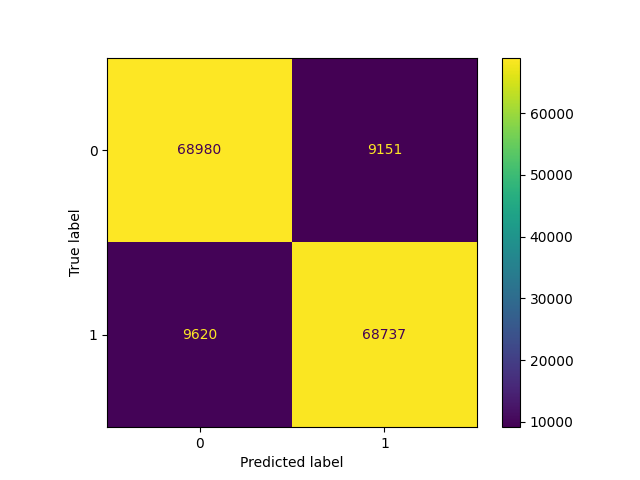

In [92]:
%matplot plt

In [93]:
reviews=xtest

#Need to join y_pred back to initial set to see if CS label or not
#Join actual ys back in as well so that we can compare predicted vs actual along w/ if CS or not
reviews['model_NR'] = y_pred
reviews['NR'] = ytest
reviews.head()

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

            UGC_ID                                           REVIEW_HEADLINE  \
52114    284021619  Product is not even shipped for 4-5 weeks after ordering   
351872   308870344  Not purchased                                              
3728168  269825691  Looks lovely however is flimsy                             
3870387  268558199  Not very bright                                            
4520499  318630109  Yes I would buy again                                      

                                                                                                                                                                                                                                                                                                                                                                                                                            REVIEW_COMMENTS  \
52114    I ordered this rug and expect it will have the quality of most products from th

In [94]:
#reviews['regex_CS'] = reviews['ALL_TEXT'].str.contains(r'(CUSTOMER SERVICE|SHIP|STATUS|ORDER|DELIVER|RECEIVE|RECIEVE|REFUND|RETURN)', case=False)==True
reviews['regex_CS'] = reviews['ALL_TEXT'].str.contains(r'(\?|PLEASE|HELP)', case=False)==True

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

/usr/local/lib64/python3.7/site-packages/pandas/core/strings/accessor.py:101: UserWarning: This pattern has match groups. To actually get the groups, use str.extract.
  return func(self, *args, **kwargs)
<string>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

In [95]:
reviews['model_CS'] = 0

reviews.loc[(reviews['model_NR'] == 1) & (reviews['regex_CS'] == True), 'model_CS' ] = 1


VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

<string>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/usr/local/lib64/python3.7/site-packages/pandas/core/indexing.py:1720: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(loc, value, pi)

In [96]:
reviews.head()

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

            UGC_ID                                           REVIEW_HEADLINE  \
52114    284021619  Product is not even shipped for 4-5 weeks after ordering   
351872   308870344  Not purchased                                              
3728168  269825691  Looks lovely however is flimsy                             
3870387  268558199  Not very bright                                            
4520499  318630109  Yes I would buy again                                      

                                                                                                                                                                                                                                                                                                                                                                                                                            REVIEW_COMMENTS  \
52114    I ordered this rug and expect it will have the quality of most products from th

In [97]:
FP = reviews[(reviews['CS'] == 0) & (reviews['model_CS'] == 1)]
FN = reviews[(reviews['CS'] == 1) & (reviews['model_CS'] == 0)]
TP = reviews[(reviews['CS'] == 1) & (reviews['model_CS'] == 1)]
TN = reviews[(reviews['CS'] == 0) & (reviews['model_CS'] == 0)]


VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [98]:
FP['UGC_ID'].count()

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

8302

In [99]:
FN['UGC_ID'].count()

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

2077

In [100]:
TP['UGC_ID'].count()

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

1781

In [101]:
TN['UGC_ID'].count()

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

144328

In [102]:
pd.set_option('display.max_colwidth', -1)
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)
FP.head(100)

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

            UGC_ID  \
377922   270350263   
211095   323612736   
5962585  278042677   
177736   326276288   
62656    276348016   
232158   318678690   
52220    275648296   
180034   316032681   
251932   277479790   
271548   280616674   
115119   320609688   
229883   265048612   
183697   264324527   
63383    281644114   
387706   283666340   
120005   281625403   
15511    318499363   
160531   276268094   
281700   288264860   
290324   326936422   
168516   275529062   
178203   321599999   
46615    326812074   
173558   284427710   
268609   325408379   
259154   280932736   
190748   297499695   
161291   319132039   
236004   318151090   
58080    265341618   
5467100  276214278   
3067231  280591721   
299165   275898319   
254213   318719574   
11910    322894980   
332974   323740881   
137625   323677374   
32438    311912205   
162386   318565037   
4834592  297132065   
307998   306712388   
238033   319867750   
234459   301966152   
74159    293172014   
269811   2

In [136]:
from pyspark.sql.types import *

mySchema = StructType([StructField("UGC_ID", StringType(), True)\
,StructField("REVIEW_HEADLINE", StrcingType(), True)\
,StructField("REVIEW_COMMENTS", StringType(), True)\
,StructField("REVIEW_RATING", IntegerType(), True)\
,StructField("CS", IntegerType(), True)\
,StructField("ALL_TEXT", StringType(), True)\
,StructField("model_NR", IntegerType(), True)\
,StructField("NR", IntegerType(), True)\
,StructField("regex_CS", StringType(), True)\
,StructField("model_CS", IntegerType(), True)])   



VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [137]:
SNOWFLAKE_SOURCE_NAME = "net.snowflake.spark.snowflake"

sfOptions = {
  'sfURL' : 'powerreviews.snowflakecomputing.com',
  'sfAccount' : 'powerreviews',
  'sfUser' : username,
  'sfPassword' : password,
  'sfDatabase' : 'ANALYTICS_WORKSHOP',
  'sfSchema' : 'DATA_SCIENCE',
  'sfWarehouse' : 'LOWER_ENV_WAREHOUSE'
}

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [140]:
#Turn into spark dataframe in order to write to Snowflake
#Couldn't get write_pandas() to work to write directly from pandas to Snowflake
FN = spark.createDataFrame(FN, schema=mySchema)

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [143]:
FP.write.format(SNOWFLAKE_SOURCE_NAME).options(**sfOptions) \
    .option("dbtable","CS_FP_test2_qmarkonly").mode("append").save()


VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [80]:
#conn.cursor().execute("drop table if exists ANALYTICS_WORKSHOP.DATA_SCIENCE.CS_FN_test2")
conn.cursor().execute("drop table if exists ANALYTICS_WORKSHOP.DATA_SCIENCE.CS_FP_test1")
#conn.cursor().execute("drop table if exists ANALYTICS_WORKSHOP.DATA_SCIENCE.CS_FP_test2")
#conn.cursor().execute("drop table if exists ANALYTICS_WORKSHOP.DATA_SCIENCE.TEST_NLP_SPARK6")
#conn.cursor().execute("drop table if exists ANALYTICS_WORKSHOP.DATA_SCIENCE.TEST_NLP_SWAP_TOKENS")

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [62]:
#Evaluating model performance
#There are inherently mostly NOLABEL so accuracy could be high just bc of those
#Want to make sure that when there is a label besides NOLABEL that it is being accurately predicted


VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [103]:
#Model performance metrics
#Assess at individual label level as well as overall

#Accuracy is overall correct predictions - not great measurement tool for imbalanced data
#Precision - TP / TP + FP = spam detection - don't want to mark something as spam (FP) when it isn't
#Recall - TP / TP + FN = sickness - don't want to tell someone they aren't sick (FN) when they are and can spread it
#F1 - balance of precision and recall

#We want to make sure if bomb emoji then it gets marked - even at the expense of marking other things potentially offensive that aren't 
#Important not to have FN - USE RECALL
#Also don't want to be marking a bunch of stuff as offensive when it isn't and making moderation do everything anyway
#Important not to have too many FP - USE PRECISION
#Use F1 for balance between both
print("Accuracy is:  {}" .format(accuracy_score(ytest, y_pred)))
print("Precision is:  {}" .format(precision_score(ytest, y_pred)))
print("Recall is:  {}" .format(recall_score(ytest, y_pred)))
print("F1 Score is:  {}" .format(f1_score(ytest, y_pred)))

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

Accuracy is:  0.880048310413578
Precision is:  0.882510784716516
Recall is:  0.8772285820028842
F1 Score is:  0.8798617555761784

In [48]:
print(classification_report(ytest,y_pred))

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

              precision    recall  f1-score   support

           0       0.87      0.89      0.88     78131
           1       0.89      0.87      0.88     78131

    accuracy                           0.88    156262
   macro avg       0.88      0.88      0.88    156262
weighted avg       0.88      0.88      0.88    156262

In [49]:
probs = clf.predict_proba(xtest_final)
preds = probs[:,1]
fpr, tpr, threshold = roc_curve(ytest, preds)
roc_auc = metrics.auc(fpr, tpr)
#print(roc_auc)

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [333]:
plt.clf()

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [334]:
#ROC CURVE
#Assumes we care about 0 and 1 classification the same - we don't
#We care more about performance of 1 classification - use precision recall curve
plt.title('Receiver Operating Characteristic')
plt.plot(fpr, tpr, 'b', label = 'AUC = %0.4f' % roc_auc)
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

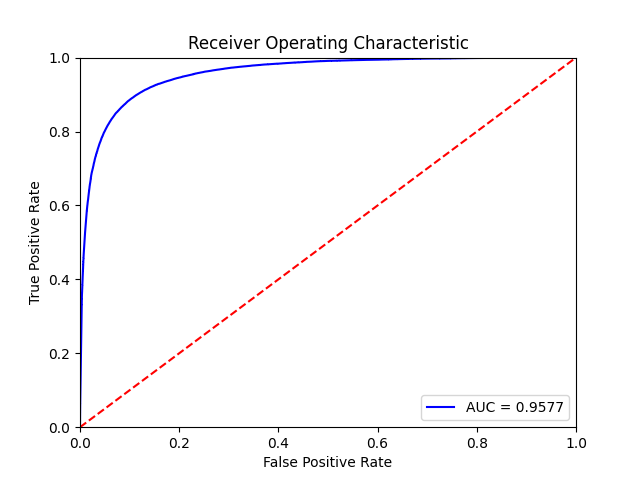

In [335]:
%matplot plt

In [336]:
#Find best threshold (ROC Curve)
#Ideally want tpr = 1 and fpr = 0, so want tpr - fpr as close to 1 as possible
optimal_idx = np.argmax(tpr - fpr)
optimal_threshold = threshold[optimal_idx]
opt_tpr = tpr[optimal_idx]
opt_fpr = fpr[optimal_idx]
print("Optimal threshold value:", optimal_threshold)
print("Optimal tpr value:", opt_tpr)
print("Optimal fpr value:", opt_fpr)

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

Optimal threshold value: 0.5011553148098223
Optimal tpr value: 0.8880537279631401
Optimal fpr value: 0.10233007623751744

In [337]:
t = optimal_threshold
y_pred_new = (preds >= t).astype(int)
#y_pred_new

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [338]:
#Scores with best threshold cutoff
print("Accuracy is:  {}" .format(accuracy_score(ytest, y_pred_new)))
print("Precision is:  {}" .format(precision_score(ytest, y_pred_new)))
print("Recall is:  {}" .format(recall_score(ytest, y_pred_new)))
print("F1 Score is:  {}" .format(f1_score(ytest, y_pred_new)))

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

Accuracy is:  0.892861849330112
Precision is:  0.89667543885587
Recall is:  0.8880537279631401
F1 Score is:  0.8923437584294185

In [339]:
len(y_pred_new)

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

204885

In [341]:
#PRECISION RECALL CURVE
#Better for what we want to assess which is how well label is assigned (i.e. when it gets a 1 instead of a 0)

precision, recall, pr_threshold = precision_recall_curve(ytest, preds)
pr_auc = metrics.auc(recall, precision)

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [342]:
plt.clf()

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [343]:
plt.title('Precision - Recall Curve')
plt.plot(recall, precision, 'b', label = 'AUC = %0.4f' % pr_auc)
plt.legend(loc = 'lower right')
no_skill = len(ytest[ytest['NR']==1]) / len(ytest)
plt.plot([0, 1], [no_skill, no_skill], 'r--', label='No Skill')
#plt.xlim([0, 1])
#plt.ylim([0, 1])
plt.ylabel('Precision')
plt.xlabel('Recall')
plt.show()

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

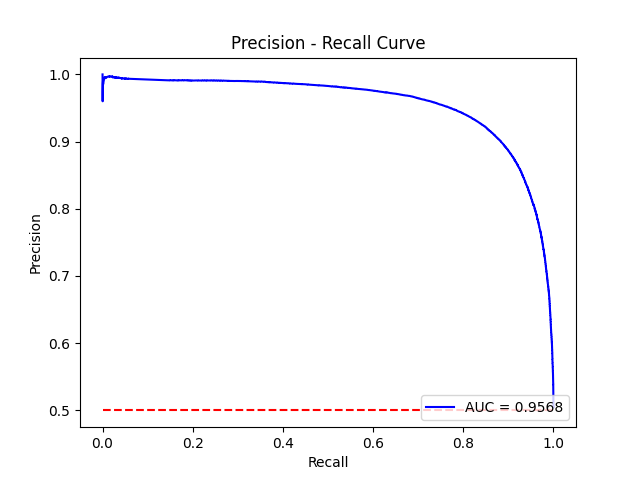

In [344]:
%matplot plt

In [345]:
#Best F1 score optimizes precision recall trade off

fscore = (2 * precision * recall) / (precision + recall)
ix = argmax(fscore)
print('Best Threshold=%f, F-Score=%.3f' % (pr_threshold[ix], fscore[ix]))

print('Recall=%f' % recall[ix])
print('Precision=%f' % precision[ix])

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

Best Threshold=0.445000, F-Score=0.893
Recall=0.904902
Precision=0.882101

In [346]:
plt.clf()

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [347]:
plt.hist(preds, bins=10)
plt.show()

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

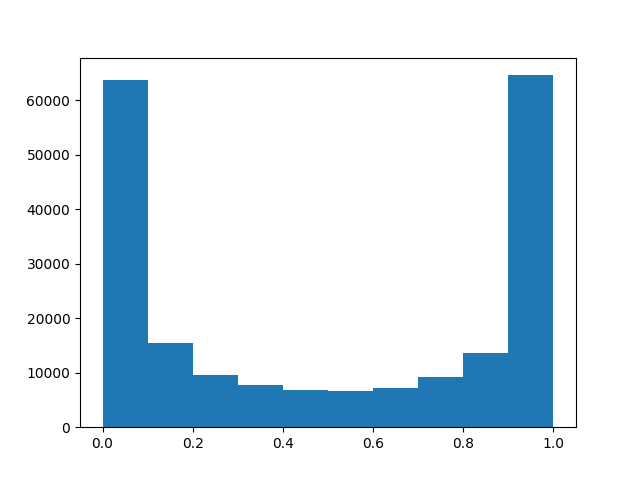

In [348]:
%matplot plt

In [349]:
preds_df = pd.DataFrame(data=preds, columns = ['pred_prob'])
#preds_df

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [350]:
ytest.reset_index(drop=True, inplace=True)
preds_df.reset_index(drop=True, inplace=True)

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [351]:
hist_plot_data = pd.concat([ytest, preds_df], axis = 1)
#hist_plot_data

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [352]:
NR_0 = hist_plot_data.loc[hist_plot_data.NR == 0, 'pred_prob']
NR_1 = hist_plot_data.loc[hist_plot_data.NR == 1, 'pred_prob']

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [356]:
plt.clf()

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [357]:
kwargs = dict(alpha=0.5, bins=20)

plt.hist(NR_0, **kwargs, color='b', label='NR=0')
plt.hist(NR_1, **kwargs, color='g', label='NR=1')
plt.gca().set(title='Histogram of NR Label Probs', ylabel='Frequency', xlabel = 'Predicted Probability')
plt.legend();

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

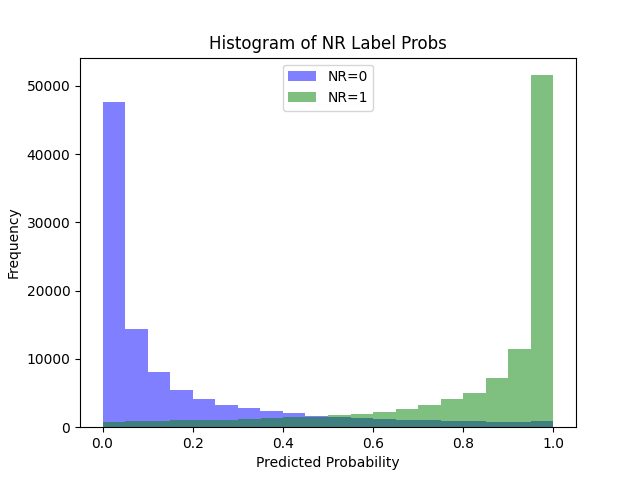

In [358]:
%matplot plt

In [316]:
#Amount of data that is actually 0 but predicted as 1 with probability > 80%
hist_plot_data.loc[(hist_plot_data.NR == 0) & (hist_plot_data.pred_prob > 0.8)].count()
#3233 / 204885 = ~1%

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

NR           3233
pred_prob    3233
dtype: int64

In [317]:
#Amount of data that is actually 1 but predicted as 0 with probability < 20%
hist_plot_data.loc[(hist_plot_data.NR == 1) & (hist_plot_data.pred_prob < 0.2)].count()
#3683 / 204885 = ~1%

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

NR           3683
pred_prob    3683
dtype: int64

In [318]:
#Amount of data (0 or 1) that is between probabilities 20% - 80%
hist_plot_data.loc[(hist_plot_data.pred_prob <0.8) & (hist_plot_data.pred_prob > 0.2)].count()
#47346 / 204885 = ~23%

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

NR           47346
pred_prob    47346
dtype: int64

In [161]:
#importance = clf.coef_
#importance

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [162]:

#feature_names = vectorizer.get_feature_names()
#dense = importance
#denselist = dense.tolist()
#df = pd.DataFrame(denselist, columns=feature_names)
#df

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [287]:
xtest.reset_index(drop=True, inplace=True)
hist_plot_data.reset_index(drop=True, inplace=True)

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [303]:
results = pd.concat([xtest, hist_plot_data], axis=1)
results

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

                                                                                                                                                                                                                                                                                                                                                                                                                           ALL_TEXT  \
0       headline Daughter loves it!! comment This is so cute, my daughter loves all the robots from Star Wars, and here they are all on one shirt!!                                                                                                                                                                                                                                                                                   
1       headline Love these too!!! comment The warmest earmuffs I have ever used in my life and they don't even make my ears sweat!! These are the best ea

In [304]:
results['ALL_TEXT'] = results['ALL_TEXT'].astype(str)
results

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

                                                                                                                                                                                                                                                                                                                                                                                                                           ALL_TEXT  \
0       headline Daughter loves it!! comment This is so cute, my daughter loves all the robots from Star Wars, and here they are all on one shirt!!                                                                                                                                                                                                                                                                                   
1       headline Love these too!!! comment The warmest earmuffs I have ever used in my life and they don't even make my ears sweat!! These are the best ea

In [305]:
results_sparkdf = spark.createDataFrame(results)

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [306]:
sfOptions2 = {
  'sfURL' : 'powerreviews.snowflakecomputing.com',
  'sfAccount' : 'powerreviews',
  'sfUser' : 'APP_SPARK_PROD',
  'sfPassword' : '>6txhcQ*7&^Qrq`j',
  'sfDatabase' : 'ANALYTICS_WORKSHOP',
  'sfSchema' : 'DATA_SCIENCE',
  'sfWarehouse' : 'LOWER_ENV_WAREHOUSE'
}


VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [307]:
 results_sparkdf.write.format(SNOWFLAKE_SOURCE_NAME).options(**sfOptions2) \
    .option("dbtable","MODLABEL_TEST_2").mode("append").save()

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…